

# Leaf Segmentation with <img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="200">

Trains a detectron2 model on Superfund leaf dataset.



# Setup

### Install requirements

In [1]:
%%capture

# requirements
!pip install pyyaml==5.1
!pip install opencv-python
!pip install matplotlib
!pip install openpyxl
!pip install funcy

# cocosplit requirements
!pip install sklearn funcy argparse scikit-multilearn

### Import Detectron2 and other Python Libraries

In [2]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

torch:  2.0 ; cuda:  cu117


# Prepare the Data

### Split dataset into train and test sets for k-fold cross validation

To make better use our small dataset (~176 images), we use k-fold cross validation.

First, we add some variables to specify where output from this training run should be stored, including the split k-fold test/train annotations and final model weights.  Set `today` to today's date and set `suffix` to specify how you'd like your output folder named (defaults to `kfold_train`).

In [6]:
today = "2024-03-15"

suffix = "kfold_train"

output_folder = '/home/jovyan/work/mask_rcnn/' + today + '_' + suffix
annotation_file = '/home/jovyan/work/data/2024-03-14_leaves_rotated.json'
data_folder = '/home/jovyan/work/data/2024-03-14_leaves'
os.makedirs(output_folder, exist_ok=True)

Next set the number of folds for k-fold cross validation (defaults to k=5, which is pretty standard).

In [7]:
# number of folds for k-fold cross validation
k = 5

Next we run the `cocosplit_kfold` script to split the images into k folds and get the training and test sets for each iteration of k-fold cross validation. You can add the `-p` flag if you'd like to see the train/test indicies for each k-fold iteration to verify this is working as expected.

In [8]:
# shuffle and randomly split into k folds
run = f"python /home/jovyan/work/mask_rcnn/cocosplit_kfold.py\
         -k {k}\
         {annotation_file}\
         {output_folder}"

!{run}

Filtered out 36 images missing manual area calculations.
Final dataset size: 176 images

Fold 0
Training set size: 140 
Test set size: 36

Fold 1
Training set size: 141 
Test set size: 35

Fold 2
Training set size: 141 
Test set size: 35

Fold 3
Training set size: 141 
Test set size: 35

Fold 4
Training set size: 141 
Test set size: 35


Now, in the output folder, you should see JSON files containing the annotations for the training & test set for each iteration of k-fold cross validation.  For example `train_0.json` and `test_0.json` respectively contain the training and test annotations for the first training iteration.

### Register the dataset with Detectron2

Register the leaf dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [9]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

def maybe_unregister(name):
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
    if name in MetadataCatalog.list():
        MetadataCatalog.remove(name)

for fold in range(0, k):
    # Define dataset names
    train_dataset_name = f"train_{fold}"
    val_dataset_name = f"val_{fold}"

    # Unregister if they already exist
    maybe_unregister(train_dataset_name)
    maybe_unregister(val_dataset_name)

    # Paths to your JSON and image data
    train_json_path = f"{output_folder}/train_{fold}.json"
    val_json_path = f"{output_folder}/test_{fold}.json"
    image_root_path = f"{data_folder}"

    # Register the datasets again
    register_coco_instances(train_dataset_name, {}, train_json_path, image_root_path)
    register_coco_instances(val_dataset_name, {}, val_json_path, image_root_path)


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



WARNING [03/15 17:15:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/15 17:15:21 d2.data.datasets.coco]: Loaded 140 images in COCO format from /home/jovyan/work/mask_rcnn/2024-03-15_kfold_train/train_0.json
Metadata(name='train_0', json_file='/home/jovyan/work/mask_rcnn/2024-03-15_kfold_train/train_0.json', image_root='/home/jovyan/work/data/2024-03-14_leaves', evaluator_type='coco', thing_classes=['leaf', 'qr', 'red-square'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})
/home/jovyan/work/data/2024-03-14_leaves/IMG_5995.JPG


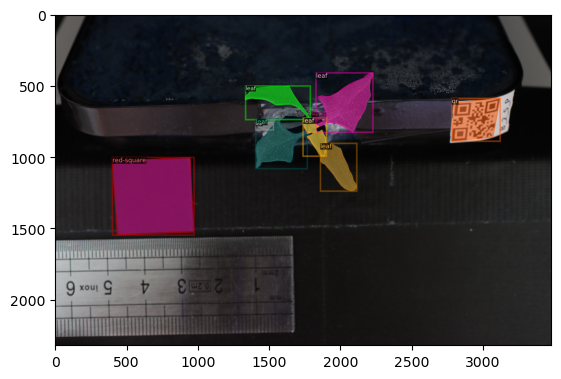

/home/jovyan/work/data/2024-03-14_leaves/IMG_5972.JPG


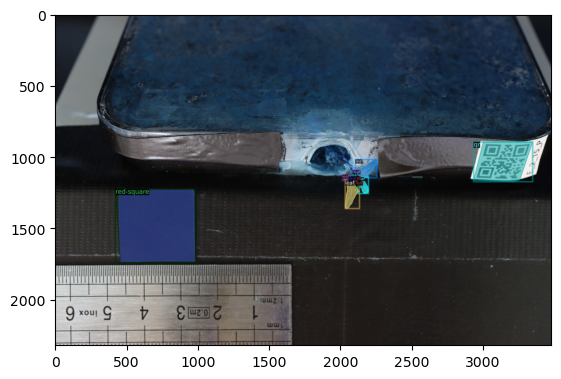

/home/jovyan/work/data/2024-03-14_leaves/IMG_5937.JPG


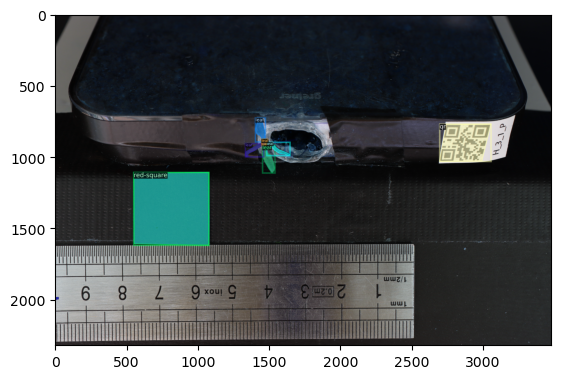

In [10]:
# import os
# os.chdir('../work/data/2024-03-14_leaves')

leaf_metadata = MetadataCatalog.get("train_0")
dataset_dicts = DatasetCatalog.get("train_0")

print(leaf_metadata)

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=leaf_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()


# Time to Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the leaf dataset.


In [11]:
import os

import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import CityscapesSemSegEvaluator, DatasetEvaluators, SemSegEvaluator
from detectron2.projects.deeplab import add_deeplab_config, build_lr_scheduler


def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN,
            cfg.INPUT.MAX_SIZE_TRAIN,
            cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        ),
        T.RandomFlip(),
        T.RandomBrightness(0.8, 1.2)
    ]

    return augs


class AugmentedTrainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains a number pre-defined logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can use the cleaner
    "SimpleTrainer", or write your own training loop.
    """

    @classmethod
    def build_train_loader(cls, cfg):
        
        print('Building custom train loader...')
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)



In [ ]:
from detectron2.engine import DefaultTrainer

for fold in range(0, 5):

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    
    cfg.DATASETS.TRAIN = (f"train_{fold}",)
    cfg.DATASETS.TEST = ()
    
    cfg.DATALOADER.NUM_WORKERS = 2
    
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 5000   
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # leaf dataset has 3 classes (leaf, qr, red-square)
    
    cfg.OUTPUT_DIR = f'{output_folder}/fold_{fold}'
    # cfg.INPUT.MIN_SIZE_TRAIN = 1160  # This sets the minimum size of the image's shortest side.
    # cfg.INPUT.MAX_SIZE_TRAIN = 3480
    # cfg.INPUT.CROP.ENABLED = True
    
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = AugmentedTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()


[03/15 17:19:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[03/15 17:19:37 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/15 17:19:58 d2.utils.events]:  eta: 1:29:01  iter: 19  total_loss: 3.835  loss_cls: 1.505  loss_box_reg: 0.2189  loss_mask: 0.6925  loss_rpn_cls: 1.293  loss_rpn_loc: 0.175    time: 1.0267  last_time: 1.1488  data_time: 0.8213  last_data_time: 0.9411   lr: 4.9953e-06  max_mem: 2247M
[03/15 17:20:20 d2.utils.events]:  eta: 1:31:19  iter: 39  total_loss: 3.327  loss_cls: 1.338  loss_box_reg: 0.2417  loss_mask: 0.6891  loss_rpn_cls: 0.8544  loss_rpn_loc: 0.195    time: 1.0166  last_time: 1.1185  data_time: 0.8052  last_data_time: 0.9128   lr: 9.9902e-06  max_mem: 2329M
[03/15 17:20:42 d2.utils.events]:  eta: 1:30:28  iter: 59  total_loss: 2.67  loss_cls: 1.102  loss_box_reg: 0.3122  loss_mask: 0.6808  loss_rpn_cls: 0.3956  loss_rpn_loc: 0.1001    time: 1.0456  last_time: 1.0950  data_time: 0.9017  last_data_time: 0.8890   lr: 1.4985e-05  max_mem: 2329M
[03/15 17:21:05 d2.utils.events]:  eta: 1:30:06  iter: 79  total_loss: 2.259  loss_cls: 0.8295  loss_box_reg: 0.3815  loss_mask: 0.670

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[03/15 18:49:41 d2.engine.train_loop]: Starting training from iteration 0
[03/15 18:50:03 d2.utils.events]:  eta: 1:29:59  iter: 19  total_loss: 4.064  loss_cls: 1.49  loss_box_reg: 0.2276  loss_mask: 0.6954  loss_rpn_cls: 1.343  loss_rpn_loc: 0.2267    time: 1.0805  last_time: 1.0532  data_time: 0.9065  last_data_time: 0.8712   lr: 4.9953e-06  max_mem: 2863M
[03/15 18:50:24 d2.utils.events]:  eta: 1:29:35  iter: 39  total_loss: 3.257  loss_cls: 1.319  loss_box_reg: 0.235  loss_mask: 0.6916  loss_rpn_cls: 0.815  loss_rpn_loc: 0.1568    time: 1.0788  last_time: 1.0298  data_time: 0.8680  last_data_time: 0.8727   lr: 9.9902e-06  max_mem: 2863M
[03/15 18:50:46 d2.utils.events]:  eta: 1:28:59  iter: 59  total_loss: 2.79  loss_cls: 1.073  loss_box_reg: 0.3199  loss_mask: 0.6845  loss_rpn_cls: 0.4293  loss_rpn_loc: 0.12    time: 1.0748  last_time: 1.0437  data_time: 0.8858  last_data_time: 0.8704   lr: 1.4985e-05  max_mem: 2863M
[03/15 18:51:07 d2.utils.events]:  eta: 1:28:27  iter: 79  tota

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[03/15 20:25:01 d2.engine.train_loop]: Starting training from iteration 0
[03/15 20:25:23 d2.utils.events]:  eta: 1:30:42  iter: 19  total_loss: 3.666  loss_cls: 1.223  loss_box_reg: 0.2004  loss_mask: 0.6933  loss_rpn_cls: 1.325  loss_rpn_loc: 0.1852    time: 1.0910  last_time: 1.1088  data_time: 0.9237  last_data_time: 0.9156   lr: 4.9953e-06  max_mem: 3097M
[03/15 20:25:45 d2.utils.events]:  eta: 1:30:08  iter: 39  total_loss: 3.096  loss_cls: 1.1  loss_box_reg: 0.2317  loss_mask: 0.6899  loss_rpn_cls: 0.8186  loss_rpn_loc: 0.1493    time: 1.0932  last_time: 1.1285  data_time: 0.9087  last_data_time: 0.9352   lr: 9.9902e-06  max_mem: 3097M
[03/15 20:26:07 d2.utils.events]:  eta: 1:29:52  iter: 59  total_loss: 2.551  loss_cls: 0.939  loss_box_reg: 0.3136  loss_mask: 0.6838  loss_rpn_cls: 0.4918  loss_rpn_loc: 0.1852    time: 1.0913  last_time: 1.0567  data_time: 0.9024  last_data_time: 0.8861   lr: 1.4985e-05  max_mem: 3097M
[03/15 20:26:29 d2.utils.events]:  eta: 1:29:23  iter: 79  

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[03/15 21:56:08 d2.engine.train_loop]: Starting training from iteration 0
[03/15 21:56:30 d2.utils.events]:  eta: 1:29:28  iter: 19  total_loss: 3.632  loss_cls: 1.456  loss_box_reg: 0.2634  loss_mask: 0.6921  loss_rpn_cls: 1.037  loss_rpn_loc: 0.1549    time: 1.0822  last_time: 1.0875  data_time: 0.9142  last_data_time: 0.8989   lr: 4.9953e-06  max_mem: 3097M
[03/15 21:56:52 d2.utils.events]:  eta: 1:29:11  iter: 39  total_loss: 3.286  loss_cls: 1.301  loss_box_reg: 0.2418  loss_mask: 0.6879  loss_rpn_cls: 0.8473  loss_rpn_loc: 0.1246    time: 1.0867  last_time: 1.0821  data_time: 0.9043  last_data_time: 0.9095   lr: 9.9902e-06  max_mem: 3097M
[03/15 21:57:14 d2.utils.events]:  eta: 1:28:54  iter: 59  total_loss: 2.692  loss_cls: 1.065  loss_box_reg: 0.3445  loss_mask: 0.6797  loss_rpn_cls: 0.4906  loss_rpn_loc: 0.1487    time: 1.0845  last_time: 1.0530  data_time: 0.8953  last_data_time: 0.8564   lr: 1.4985e-05  max_mem: 3097M
[03/15 21:57:35 d2.utils.events]:  eta: 1:28:28  iter: 79

In [ ]:
!pip install jupyter-tensorboard

In [ ]:


# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir ./{output_folder}/fold_{fold} --port 6007

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("val")
leaf_metadata = MetadataCatalog.get("val")

for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=leaf_metadata, 
                   # scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()